In [ ]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [ ]:
# For face detection mtcnn is used
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.4 MB/s 


In [ ]:
# packages imported
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Python Imaging Library for opeations on image
from PIL import Image
from numpy import asarray

In [ ]:
from mtcnn.mtcnn import MTCNN

In [ ]:

from keras.models import Model,model_from_json,load_model

In [ ]:
from keras.layers import Layer,Input


In [ ]:
from tensorflow.keras.optimizers import Adam


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
import keras.backend as K


In [ ]:
# Location of the model 
model_path = "Models/Inception_ResNet_v1.json"

In [ ]:
ls

'Copy of narendra modi.jpg'   LFW_dataset/         testing.jpg
 enc_trainer_model.png        Models/              Training.ipynb
 Face_Comparison.ipynb       'narendra modi.jpg'
 Images/                      test2.jpg


In [ ]:
json_file = open(model_path, 'r')


In [ ]:
loaded_model_json = json_file.read()
json_file.close()
# model_from_json parses a JSON model configuration string and returns a model instance.
enc_model = model_from_json(loaded_model_json)


In [ ]:
loaded_model_json

'{"class_name": "Model", "config": {"name": "inception_resnet_v1", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 160, 160, 3], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "Conv2d_1a_3x3", "class_name": "Conv2D", "config": {"name": "Conv2d_1a_3x3", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"name": "Conv2d_1a_3x3_BatchNorm", "class_name": "Batch

In [ ]:
# Setting the model to be trainable

enc_model.trainable = True

In [ ]:
# Initializing the MTCNN face detector

mtcnn_detector = MTCNN()

In [ ]:
# Given function detects and extracts face from the image
def detect_face(filename, required_size=(160, 160)):

	img = Image.open(filename)
	
  # convert to RGB
	img = img.convert('RGB')
 
	# convert to array
	pixels = np.asarray(img)
 
	# detect faces in the image
	results = mtcnn_detector.detect_faces(pixels)
 
	# bounding box from the first face stored in x1,y1,width,height
	x1, y1, width, height = results[0]['box']

	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height

	# extract the face in the region found above
	face = pixels[y1:y2, x1:x2]
  
	# creates an image memory
	image = Image.fromarray(face)
  # resize pixels to the required size
	image = image.resize(required_size)
	face_array = asarray(image)
 
	return face_array

In [ ]:
# faces and labels stored from the trainining dataset
# Dataset contains different images of persons stored with folder name as per their name

cropped_faces =[]
face_labels = []

# dataset path as per your training dataset path
dataset_path = "LFW_dataset"

i=0

for person in os.listdir(dataset_path):
  for filename in os.listdir(os.path.join(dataset_path,person)):

    # Detecting faces
    try :
      face = detect_face(dataset_path+'/'+person+'/'+filename)
    except:
      print(filename  + " can't be loaded !")
      continue    
    cropped_faces.append (face)

    # Save labels
    label = person
    face_labels.append(label)

    i+=1
    if i%50 == 0 :
      print(str(i)+" images loaded !") 
    
print("\nTotal "+str(i)+" images loaded !")

face_labels = np.array (face_labels)
cropped_faces = np.array(cropped_faces)
print(face_labels.shape)
print(cropped_faces.shape)  

50 images loaded !
100 images loaded !
150 images loaded !
200 images loaded !

Total 201 images loaded !
(201,)
(201, 160, 160, 3)


In [ ]:
# Printing number of unique persons loaded

n_IDs = len(np.unique(face_labels))
print(n_IDs)

20


Queen_Elizabeth_II


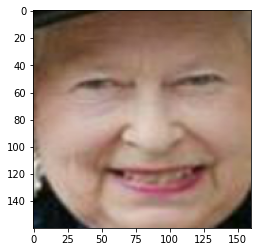

In [ ]:
# Visualizing the dataset loaded

index = 5

plt.imshow(cropped_faces[index])
print(face_labels[index])

In [ ]:
# Function to find Euclidean distance between 2 Faces
# Before calculating Euclidean distance, encoding is L2 normalized

def distance(a,b):
  a/= np.sqrt(np.maximum(np.sum(np.square(a)),1e-10))
  b/= np.sqrt(np.maximum(np.sum(np.square(b)),1e-10))

  dist = np.sqrt(np.sum(np.square(a-b)))

  return dist

In [ ]:
# Function to find Euclidean distances between 2 batch of Faces

def distance_batch(a,b):

  a/= np.sqrt(np.maximum(np.sum(np.square(a),axis=1,keepdims=True),1e-10))
  b/= np.sqrt(np.maximum(np.sum(np.square(b),axis=1,keepdims=True),1e-10))

  dist = np.sqrt(np.sum(np.square(a-b),axis=1))

  return dist

In [ ]:
# Function to standardize/Z-Score Normalize a Single face

def normalize_single(X):

  axis = (0,1,2)
 
  # calculate mean along specified axis
  mean = np.mean(X,axis)
  # calculate standard deviation along specified axis
  std = np.std(X,axis)

  size= X.size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return X

In [ ]:
# Function to standardize/Z-Score Normalize a Batch of faces

def normalize_batch(X):

  axis = (1,2,3)

  mean = np.mean(X,axis,keepdims=True)
  std = np.std(X,axis,keepdims=True)

  size = X[0].size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return X

In [ ]:
# Function to standardize/Z-Score Normalize a Triplet batch

def normalize_triplet_batch(X):

  axis = (2,3,4)

  mean = np.mean(X,axis,keepdims=True)
  std = np.std(X,axis,keepdims=True)

  size = X[0][0].size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return [X[0],X[1],X[2]]

In [ ]:
# Generate all possible Anchor-Positive Combinations from our dataset

X_anchor = []
X_positive = []

X_anchor_labels = []

persons_list = np.unique(face_labels)

for person in persons_list:

  filter_person = (face_labels==person).reshape(cropped_faces.shape[0])
  X_person = cropped_faces[filter_person]

  for face1 in range(X_person.shape[0]):
    for face2 in range(face1+1,X_person.shape[0]):

      X_anchor.append (X_person[face1])
      X_positive.append (X_person[face2])

      X_anchor_labels.append (person)

X_anchor = np.array(X_anchor)
X_positive = np.array(X_positive)

X_anchor_labels = np.array(X_anchor_labels)

print(X_anchor.shape)
print(X_positive.shape) 

(910, 160, 160, 3)
(910, 160, 160, 3)


In [ ]:
# Function to generate a batch of Triplets ( Anchor-Positive-Negative )

def get_batch(n_rand_triplets,n_hard_triplets):

  # Generate n_rand_triplets no. of Random Triplets

  filter = np.random.choice(list(range(0,X_anchor.shape[0])),int(n_rand_triplets))

  X_anchor_random  = X_anchor[filter]
  X_positive_random = X_positive[filter]
  X_negative_random = []

  X_anchor_random_labels = X_anchor_labels[filter]

  for i in range(int(n_rand_triplets)):
    flag=False
    while(flag==False):
      index = np.random.randint(0,cropped_faces.shape[0])
      if face_labels[index]!=X_anchor_random_labels[i]:
        X_negative_random.append(cropped_faces[index])
        flag=True

  X_negative_random = np.array(X_negative_random)

  # If only hard triplets required
  if n_rand_triplets == 0:
    X_negative_random = X_anchor_random # Empty arrays 

  # Generate n_hard_triplets no. of Hard Triplets ( Positive distance > Negative distance )

  X_negative_samples = []

  for i in range(X_anchor.shape[0]):

    flag=False
    while(flag==False):
      index = np.random.randint(0,cropped_faces.shape[0])
      if face_labels[index]!=X_anchor_labels[i]:
        X_negative_samples.append(cropped_faces[index])
        flag=True
    
  X_negative_samples = np.array(X_negative_samples)  

  Negative_distances = distance_batch(enc_model.predict(normalize_batch(X_anchor)),
                                      enc_model.predict(normalize_batch(X_negative_samples)))
  
  Positive_distances = distance_batch(enc_model.predict(normalize_batch(X_anchor)),
                                      enc_model.predict(normalize_batch(X_positive)))

  distances =  Negative_distances - Positive_distances

  # argsort returns an array of indices of sorted array
  filter = np.argsort(distances)[:int(n_hard_triplets)]

  X_anchor_hard = X_anchor[filter]
  X_positive_hard = X_positive[filter]
  X_negative_hard = X_negative_samples[filter]

  # Triplet batch of required size formed after concatenation

  X_anchor_batch  = np.concatenate((X_anchor_random,X_anchor_hard))
  X_positive_batch = np.concatenate((X_positive_random,X_positive_hard))
  X_negative_batch = np.concatenate((X_negative_random,X_negative_hard))

  return [X_anchor_batch,X_positive_batch,X_negative_batch]

In [ ]:
# Define Triplet Loss Custom Keras Layer

class TripletLossLayer(Layer):

    def __init__(self, margin, **kwargs):
        self.margin = margin
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
      
        anchor, positive, negative = inputs

        anchor = anchor/K.sqrt(K.maximum(K.sum(K.square(anchor),axis=1,keepdims=True),1e-10))
        positive = positive/K.sqrt(K.maximum(K.sum(K.square(positive),axis=1,keepdims=True),1e-10))
        negative = negative/K.sqrt(K.maximum(K.sum(K.square(negative),axis=1,keepdims=True),1e-10))

        p_dist = K.sqrt(K.sum(K.square(anchor-positive), axis=1))
        n_dist = K.sqrt(K.sum(K.square(anchor-negative), axis=1))

        return K.sum(K.maximum(p_dist - n_dist + self.margin, 0))
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [ ]:
#  function which creates a model that trains our Face Encoder

def create_enc_trainer(input_shape,enc_model,margin = 0.5):

    # Define Input tensors
    anchor = Input(input_shape, name="anchor_input")
    positive = Input(input_shape, name="positive_input")
    negative = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    enc_anchor = enc_model(anchor)
    enc_positive = enc_model(positive)
    enc_negative = enc_model(negative)
    
    # TripletLoss Layer
    loss_layer=TripletLossLayer(margin=margin,name='triplet_loss')([enc_anchor,enc_positive,enc_negative])
    
    # Connecting the inputs with the outputs
    enc_trainer = Model(inputs=[anchor,positive,negative],outputs=loss_layer,name = "Trainer_Model")
    
    # return the model
    return enc_trainer

Model: "Trainer_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 160, 160, 3  0           []                               
                                )]                                                    

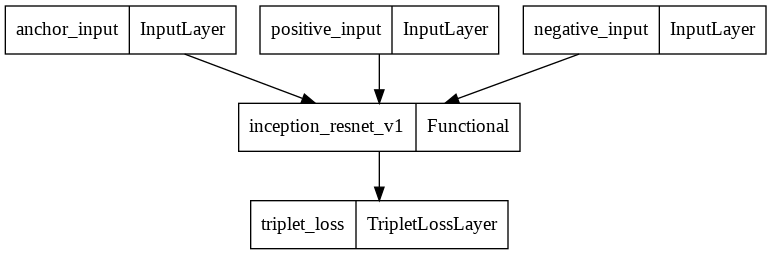

In [ ]:
# Create and compile Trainer model
# Inception ResNet v1 expects 160x160x3 RGB images with pixel values normalized across all the 3 channels, to generate 128 dimensional face encodings.

enc_trainer_model = create_enc_trainer((160,160,3),enc_model,margin = 0.5)
enc_trainer_model.compile(optimizer=Adam(learning_rate=0.0005))

enc_trainer_model.summary()
plot_model(enc_trainer_model,to_file='enc_trainer_model.png')

In [ ]:
# Training the Encoder Model 

# batch size hyperparameter is number of training examples utilized in one iteration
# random_batch_size and hard_batch_size used to generate the triplet batch
# An epoch is one cycle of training the neural network with all the training data 
epochs = 25
random_batch_size = 16
hard_batch_size = 32

losses = []

for e in range(1,epochs+1):

  mini_batch = get_batch(random_batch_size,hard_batch_size)
  loss = enc_trainer_model.train_on_batch(normalize_triplet_batch(mini_batch),None)  
  losses.append(loss)

  if(e%5 == 0):
    print("Triplet Loss after "+str(e)+' epochs : '+str(loss))

Triplet Loss after 5 epochs : 19.418582916259766
Triplet Loss after 10 epochs : 11.340012550354004
Triplet Loss after 15 epochs : 8.572669982910156
Triplet Loss after 20 epochs : 13.927037239074707
Triplet Loss after 25 epochs : 7.807400703430176


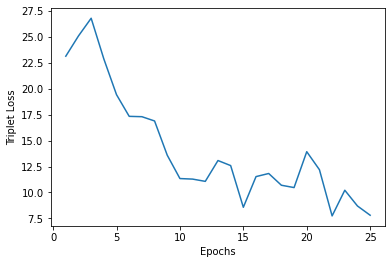

In [ ]:
# Plot Triplet Loss over training period
# As we increase the number of epochs triplet loss is minimized further 

e = list(range(1,epochs+1))

plt.plot(e,losses)
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.show()

In [ ]:
# Generate a Random Test Batch to visualize the anchor positive and negative 

test_batch = get_batch(128,0)


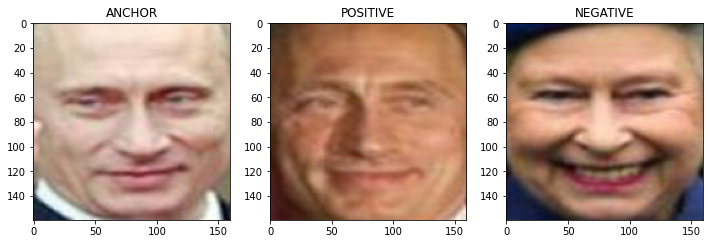

Distance between Anchor and Positive : 0.028871492
Distance between Anchor and Negative : 0.025442371


In [ ]:
# Visualize Triplets with distances between anchor positive and negative distances
# As we train further the distance between positive and anchor will decrease and distance between anchor and  negative will increase
index = 0

anchor = test_batch[0][index]
positive  = test_batch[1][index]
negative = test_batch[2][index]

plt.figure(figsize=(12,12))

# in subplot the first argument us number of rows , 2nd arguments is no of columns and 3rd argument is the index of the current plot
plt.subplot(1,3,1)
plt.imshow(anchor)
plt.title('ANCHOR')
plt.subplot(1,3,2)
plt.imshow(positive)
plt.title('POSITIVE')
plt.subplot(1,3,3)
plt.imshow(negative)
plt.title('NEGATIVE')

plt.show()

anchor_enc  = enc_model.predict(normalize_single(anchor).reshape(1,160,160,3))
positive_enc  = enc_model.predict(normalize_single(positive).reshape(1,160,160,3))
negative_enc  = enc_model.predict(normalize_single(negative).reshape(1,160,160,3))

print("Distance between Anchor and Positive : "+str(distance(anchor_enc,positive_enc)))
print("Distance between Anchor and Negative : "+str(distance(anchor_enc,negative_enc)))

In [ ]:
ls

'Copy of narendra modi.jpg'   LFW_dataset/         testing.jpg
 enc_trainer_model.png        Models/              Training.ipynb
 Face_Comparison.ipynb       'narendra modi.jpg'
 Images/                      test2.jpg


In [ ]:
# Location where the model is to be saved after training
save_at="Models/first_trained_model_kunal.h5"
enc_model.save_weights(save_at)